## Import thư viện

In [14]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

Arranging folder

In [15]:
train_folder = r'C:\Users\axeld\OneDrive\Bureau\MachineLearning\kaggle\input\train'
test_folder = r'C:\Users\axeld\OneDrive\Bureau\MachineLearning\kaggle\input\test'
valid_folder = r'C:\Users\axeld\OneDrive\Bureau\MachineLearning\kaggle\input\valid'

train_annotation_file = os.path.join(train_folder, '_annotations.txt')
test_annotation_file = os.path.join(test_folder, '_annotations.txt')
valid_annotation_file = os.path.join(valid_folder, '_annotations.txt')

class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

num_classes = len(class_names)
target_size = (224, 224)
batch_size = 32


## Annotate classes

In [ ]:

def read_annotations_class_only(file_path):
    image_labels = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            image_name = parts[0]
            try:
                class_id = int(parts[1].split(',')[-1])
                if image_name not in image_labels:
                    image_labels[image_name] = class_id
            except ValueError:
                continue
    return pd.DataFrame(list(image_labels.items()), columns=['image_name', 'class_id'])

In [ ]:

train_df = read_annotations_class_only(train_annotation_file)
valid_df = read_annotations_class_only(valid_annotation_file)
test_df = read_annotations_class_only(test_annotation_file)

train_df['image_path'] = train_df['image_name'].apply(lambda x: os.path.join(train_folder, x))
valid_df['image_path'] = valid_df['image_name'].apply(lambda x: os.path.join(valid_folder, x))
test_df['image_path'] = test_df['image_name'].apply(lambda x: os.path.join(test_folder, x))

train_df['class_id_str'] = train_df['class_id'].astype(str)
valid_df['class_id_str'] = valid_df['class_id'].astype(str)
test_df['class_id_str'] = test_df['class_id'].astype(str)


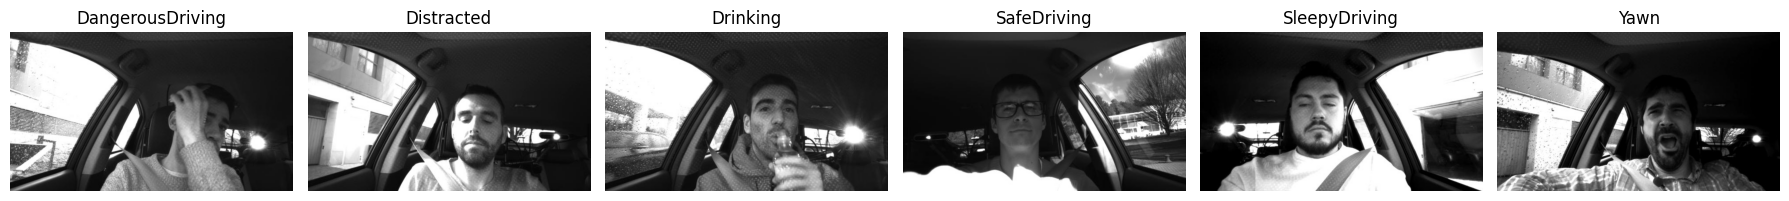

In [ ]:
plt.figure(figsize=(18, 5))

for class_id in range(num_classes):
    sample_row = train_df[train_df['class_id'] == class_id].iloc[0]
    image_path = os.path.join(train_folder, sample_row['image_name'])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(1, num_classes, class_id + 1)
    plt.imshow(image)
    plt.title(class_names[class_id])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:

class_distribution = train_df['class_id'].value_counts().sort_index()
print("Class distribution in training set:")
for class_id, count in class_distribution.items():
    print(f"Class {class_id} ({class_names[class_id]}): {count} images")

Class distribution in training set:
Class 0 (DangerousDriving): 3732 images
Class 1 (Distracted): 1676 images
Class 2 (Drinking): 347 images
Class 3 (SafeDriving): 4969 images
Class 4 (SleepyDriving): 785 images
Class 5 (Yawn): 439 images


## PreProcess

In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.85, 1.15], 
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='class_id_str',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_generator = val_test_datagen.flow_from_dataframe(
    valid_df,
    x_col='image_path',
    y_col='class_id_str',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='class_id_str',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.


## MobileNetV2

In [ ]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,046,726 (11.62 MB)

 Trainable params: 788,742 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Train

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2, 
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=7, 
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_driver_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [reduce_lr, early_stopping, model_checkpoint]

print("Phase 1: Training with frozen base model")
history1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

print("Phase 2: Fine-tuning the model")
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_fine_tuning = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_finetuned_driver_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

history2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=callbacks_fine_tuning,
    verbose=1
)


Phase 2: Fine-tuning the model
Epoch 1/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.9476 - loss: 0.2610
Epoch 1: val_accuracy improved from None to 0.93028, saving model to best_finetuned_driver_model.keras
374/374 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.9471 - loss: 0.2647 - val_accuracy: 0.9303 - val_loss: 0.3682 - learning_rate: 5.0000e-05
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.9533 - loss: 0.2375
Epoch 2: val_accuracy did not improve from 0.93028
374/374 ━━━━━━━━━━━━━━━━━━━━ 316s 846ms/step - accuracy: 0.9496 - loss: 0.2453 - val_accuracy: 0.9121 - val_loss: 0.3894 - learning_rate: 5.0000e-05
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9535 - loss: 0.2307
Epoch 3: val_accuracy improved from 0.93028 to 0.93704, saving model to best_finetuned_driver_model.keras
374/374 ━━━━━━━━━━━━━━━━━━━━ 277s 740ms/step - accuracy: 0.9530 - loss: 0.2332 - val_accuracy: 0.9370 - val_loss: 0.3055 - learning_rate: 5.0000e-05
E

In [ ]:

model.save('driver_behavior_model_optimized.keras')
print("Model saved as 'driver_behavior_model_optimized.keras'")

Model saved as 'driver_behavior_model_optimized.keras'


Evaluating model on test set:
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 561ms/step - accuracy: 0.9543 - loss: 0.2591
Test Accuracy: 0.9543
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 356ms/step


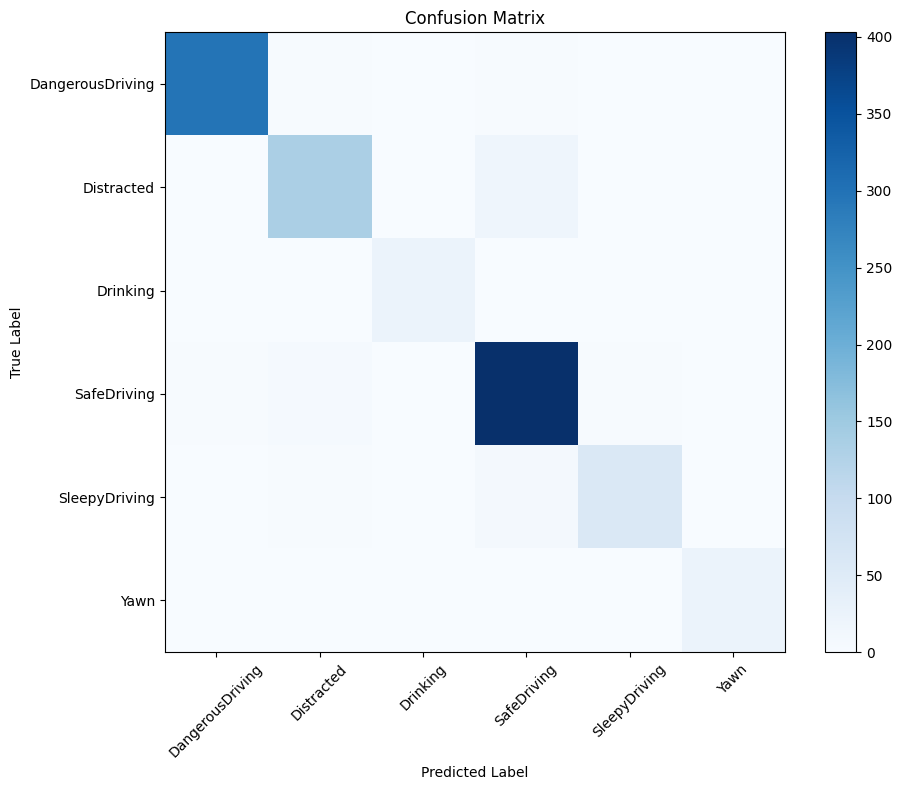

Classification Report:
                  precision    recall  f1-score   support

DangerousDriving       0.99      0.98      0.99       301
      Distracted       0.94      0.88      0.91       152
        Drinking       1.00      0.96      0.98        25
     SafeDriving       0.93      0.98      0.95       412
   SleepyDriving       0.95      0.84      0.89        69
            Yawn       0.96      0.96      0.96        26

        accuracy                           0.95       985
       macro avg       0.96      0.93      0.95       985
    weighted avg       0.95      0.95      0.95       985



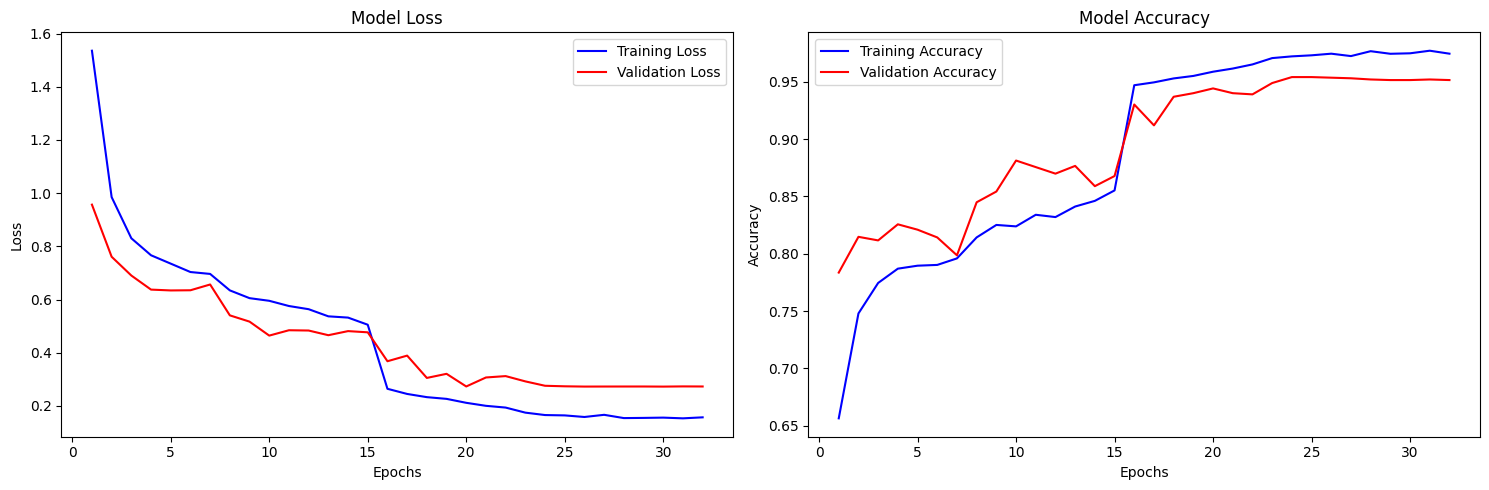

<Figure size 1200x600 with 0 Axes>

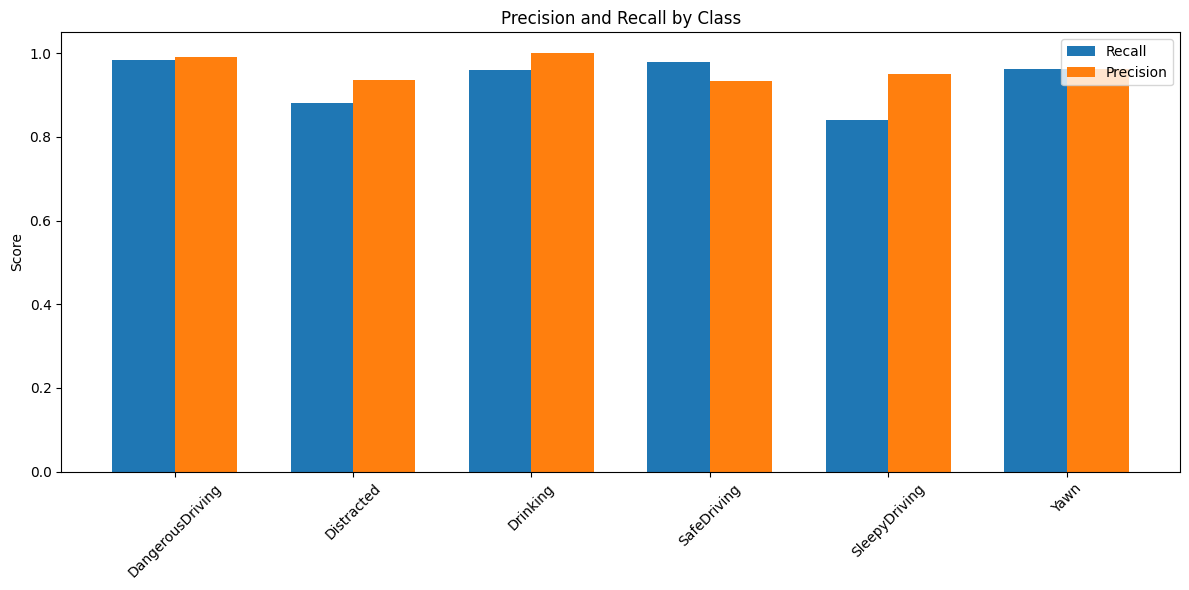

Classes with lowest recall:
Class 4 (SleepyDriving): 0.8406
Visualizing sample predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


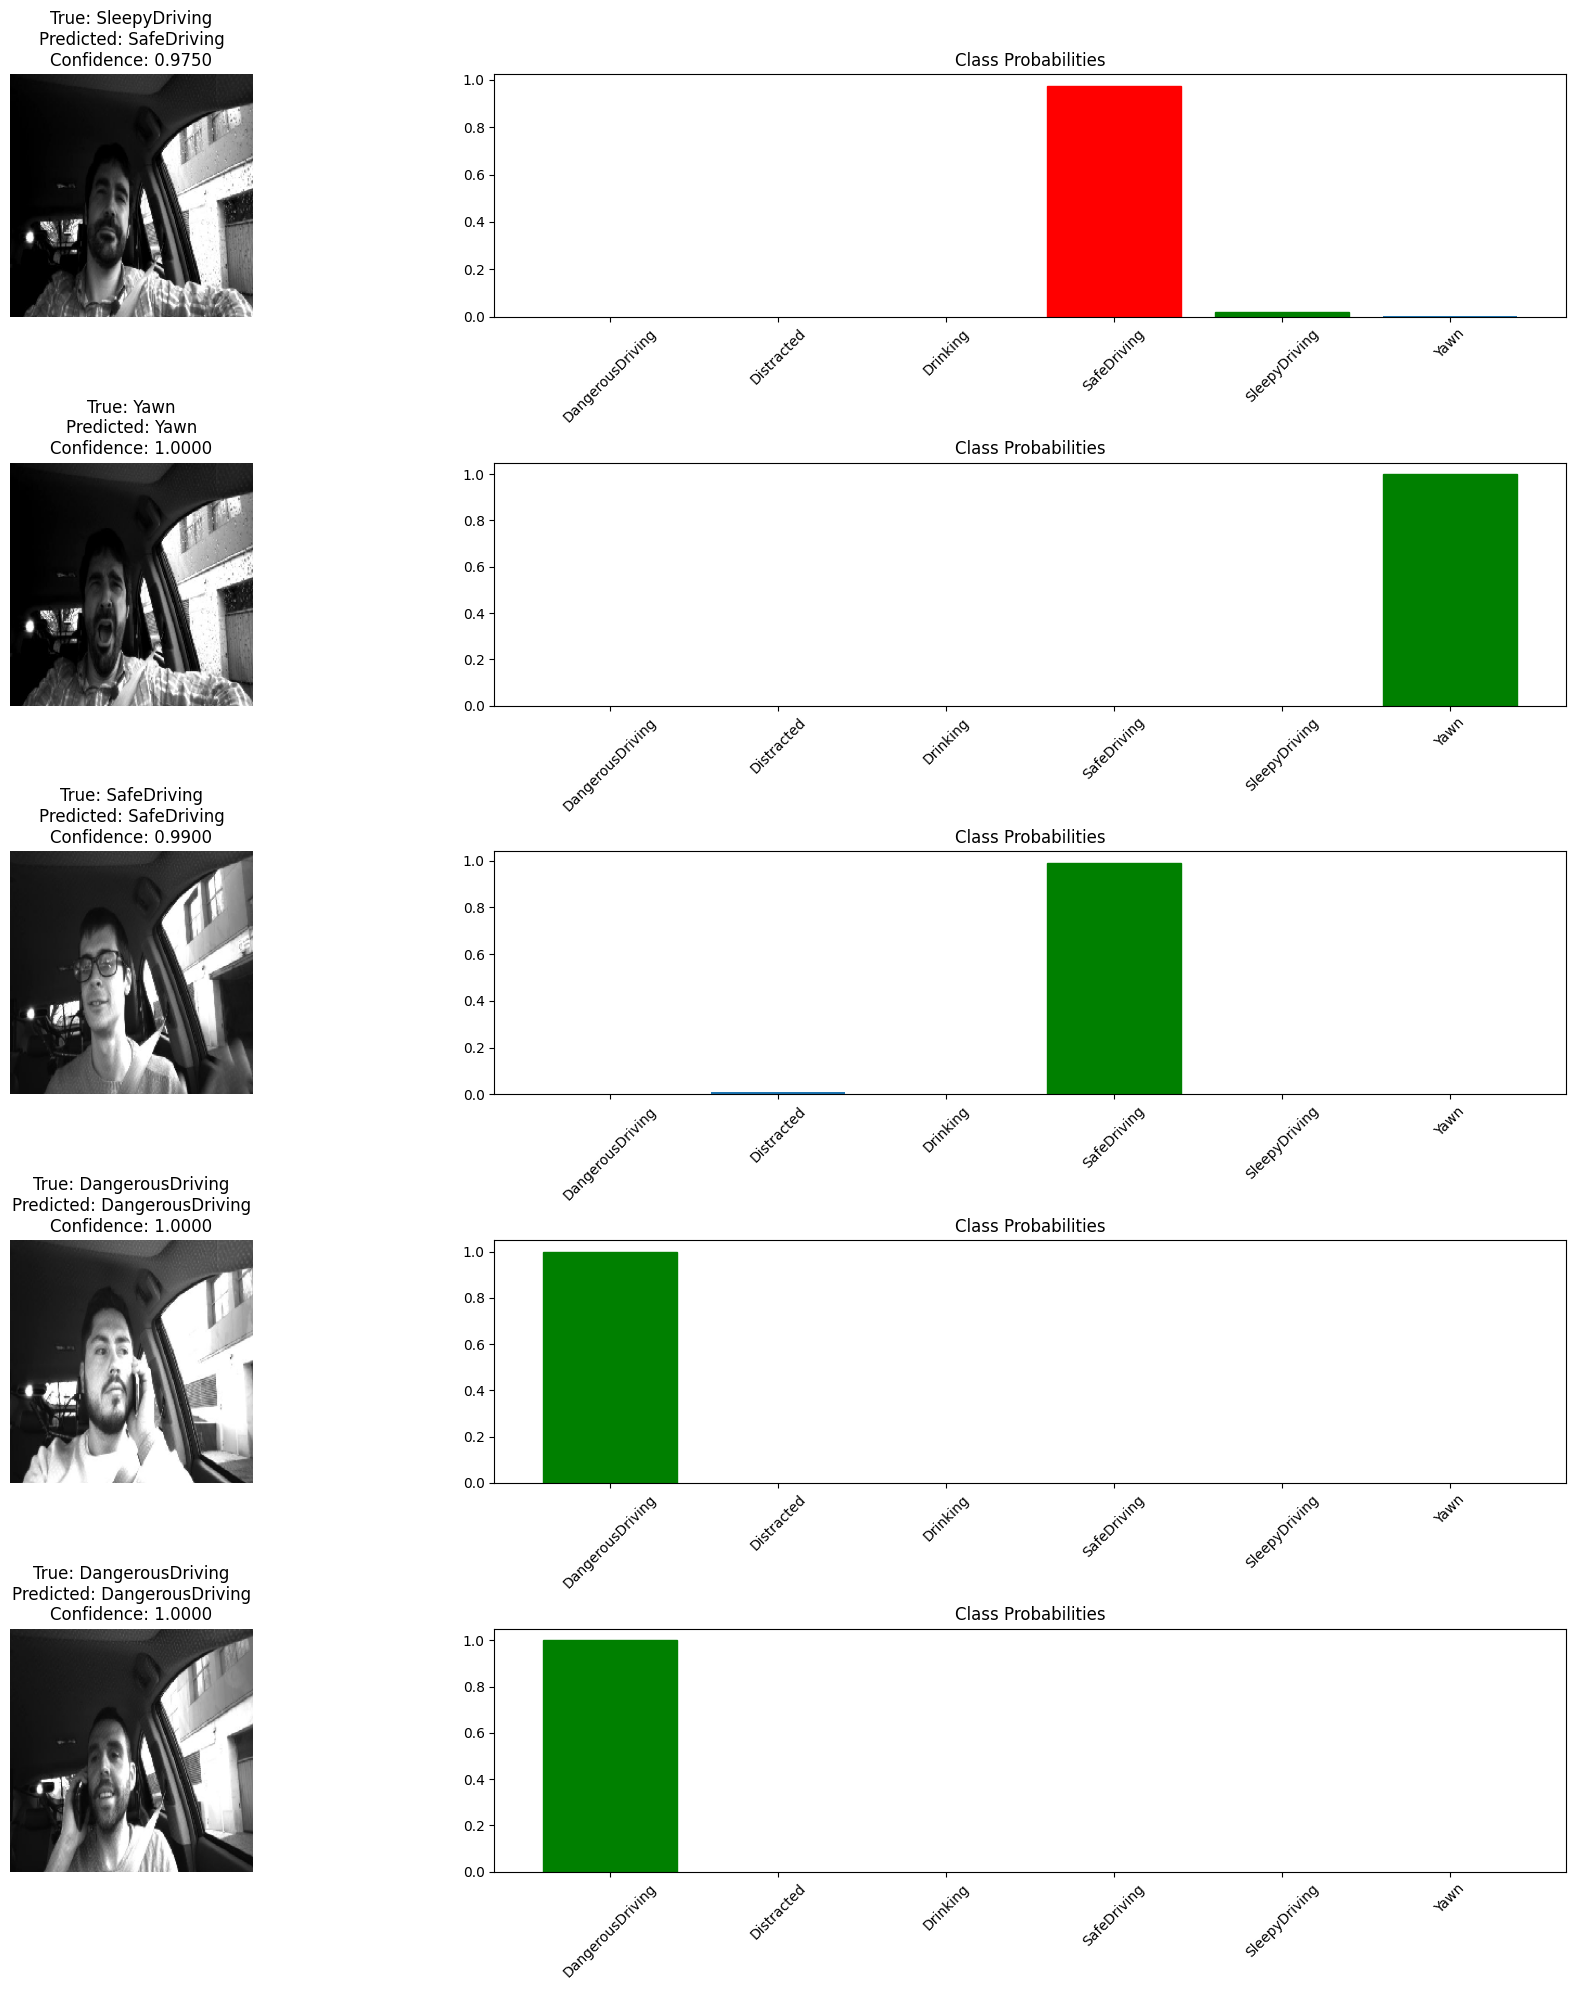

In [ ]:

print("Evaluating model on test set:")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, [class_names[i] for i in range(len(class_names))], rotation=45)
plt.yticks(tick_marks, [class_names[i] for i in range(len(class_names))])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# In classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, 
                          target_names=[class_names[i] for i in range(len(class_names))]))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
all_epochs = range(1, len(history1.history['loss']) + len(history2.history['loss']) + 1)
all_train_loss = history1.history['loss'] + history2.history['loss']
all_val_loss = history1.history['val_loss'] + history2.history['val_loss']
plt.plot(all_epochs, all_train_loss, 'b-', label='Training Loss')
plt.plot(all_epochs, all_val_loss, 'r-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
all_train_acc = history1.history['accuracy'] + history2.history['accuracy']
all_val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
plt.plot(all_epochs, all_train_acc, 'b-', label='Training Accuracy')
plt.plot(all_epochs, all_val_acc, 'r-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

def analyze_class_performance(cm, class_names):
    plt.figure(figsize=(12, 6))
    
    recall_per_class = np.diag(cm) / np.sum(cm, axis=1)
    
    precision_per_class = np.diag(cm) / np.sum(cm, axis=0)
    
    x = np.arange(len(class_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, recall_per_class, width, label='Recall')
    rects2 = ax.bar(x + width/2, precision_per_class, width, label='Precision')
    
    ax.set_ylabel('Score')
    ax.set_title('Precision and Recall by Class')
    ax.set_xticks(x)
    ax.set_xticklabels([class_names[i] for i in range(len(class_names))], rotation=45)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

    print("Classes with lowest recall:")
    for i in np.argsort(recall_per_class):
        print(f"Class {i} ({class_names[i]}): {recall_per_class[i]:.4f}")
        if len(np.argsort(recall_per_class)) > 3:  
            break

analyze_class_performance(cm, class_names)



def predict_driver_behavior(model, image_path, class_names):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    prediction = model.predict(img)
    class_idx = np.argmax(prediction)
    confidence = prediction[0][class_idx]
    
    return class_names[class_idx], confidence

def visualize_prediction(model, test_generator, class_names, num_samples=5):
    images, labels = next(test_generator)
    
    predictions = model.predict(images)
    
    plt.figure(figsize=(20, 4 * num_samples))
    for i in range(min(num_samples, len(images))):
        true_class = np.argmax(labels[i])
        pred_class = np.argmax(predictions[i])
        confidence = predictions[i][pred_class]
        
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[true_class]}\nPredicted: {class_names[pred_class]}\nConfidence: {confidence:.4f}")
        plt.axis('off')
        
        plt.subplot(num_samples, 2, 2*i+2)
        bars = plt.bar(range(len(class_names)), predictions[i])
        plt.xticks(range(len(class_names)), [class_names[j] for j in range(len(class_names))], rotation=45)
        plt.title("Class Probabilities")
        
        bars[true_class].set_color('green')
        if pred_class != true_class:
            bars[pred_class].set_color('red')
    
    plt.tight_layout()
    plt.show()

print("Visualizing sample predictions:")
visualize_prediction(model, test_generator, class_names)